In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import tqdm
from tqdm.keras import TqdmCallback

import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import MultipleLocator

import src

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

In [3]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

### Setup for data

In [4]:
expLabels = [
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 21',
    'Test 22',
    'Test 23',
]

exps = [src.load(label) for label in expLabels]

In [5]:
# Add two features for the 350-360 kHz and 900-910 kHz frequency bands

freq = [35, 90]

for i, exp in enumerate(exps):
    f = np.array(exp.ae.fft[1000])
    # avg over 10kHz
    f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
    f = f.T
    for fr in freq: 
        fNew = np.concatenate(([np.NaN], f[fr]))
        exp.features[f'Freq {fr * 10} kHz'] = fNew

### Parameters

In [6]:
doc = 0.03    # Depth of cut (mm)
tol = 0.0015   # Tolerance (mm)
# tol = 0.002   # Tolerance (mm)
overall_tol = 0.02 # Overall tolerance (mm)

# Multiclass classification (Wear In, Steady State, Wear Out)

There should be three categories of probe data relating to the three stages of tool wear:
1. Initial rapid wear in
2. Steady state wear (Much longer in time period)
3. Rapid wear out from tool failure

Therefore each test should have two crossing points to determine the three catergories.

Labelling Key:
- 0: Stage 1 (Wear in)
- 1: Stage 2 (Steady state)
- 2 : Stage 3 (Wear out)

## Data Preprocesssing & Labelling

In [7]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\tomje\AppData\Local\Temp\ipykernel_50836\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_50836\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


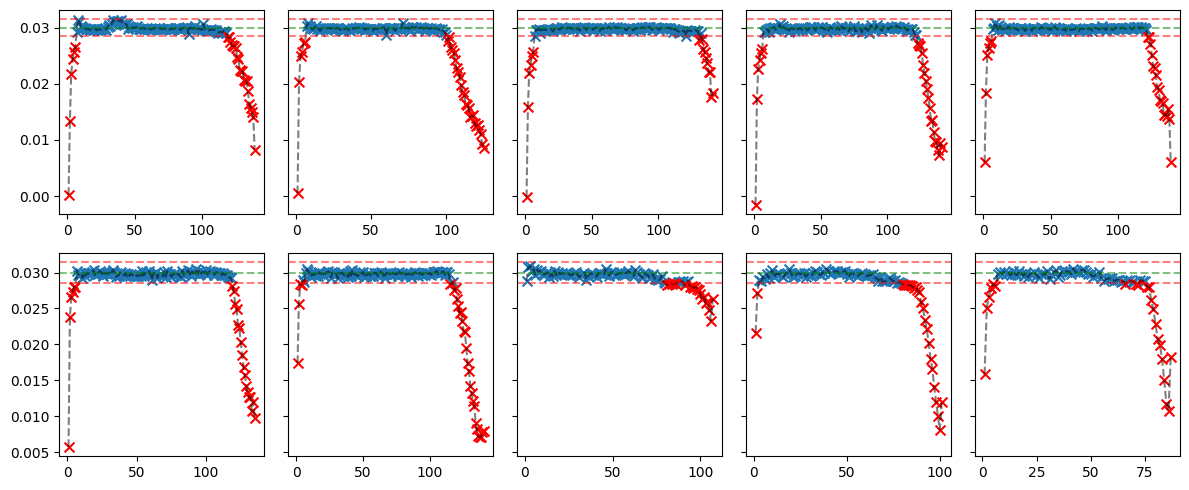

In [8]:
crossings = []

fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()
for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)

    in_tol = y.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)

    crossing = []
    for ix in x[tol_bool]:
        # if ix == 0:
        #     continue
        # if ix == len(x) - 1:
        #     continue
        if ix - 1 not in x[tol_bool]:
            crossing.append(ix)
        elif ix + 1 not in x[tol_bool]:
            crossing.append(ix)

    # if len(crossing) != 2:
    #     ix = np.argmax(np.diff(crossing))
    #     crossing = crossing[ix:ix+2]
    crossing = [crossing[1], crossing[-2]]
    crossings.append(crossing)

fig.tight_layout()


In [9]:
# test 8 has no wear in stage
crossings[7][0] = 0
crossings

[[6, 119],
 [6, 101],
 [6, 133],
 [6, 123],
 [6, 122],
 [6, 119],
 [4, 118],
 [0, 94],
 [2, 80],
 [6, 76]]

In [10]:
# Multi-class classification
categories = []
for df, cr in zip(dfs, crossings):
    categories.append(np.ones(len(df), dtype=int))
    categories[-1][:cr[0] + 1] = 0
    categories[-1][cr[1]:] = 2
    df['Probe class'] = categories[-1]

c:\Users\tomje\.conda\envs\tf\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


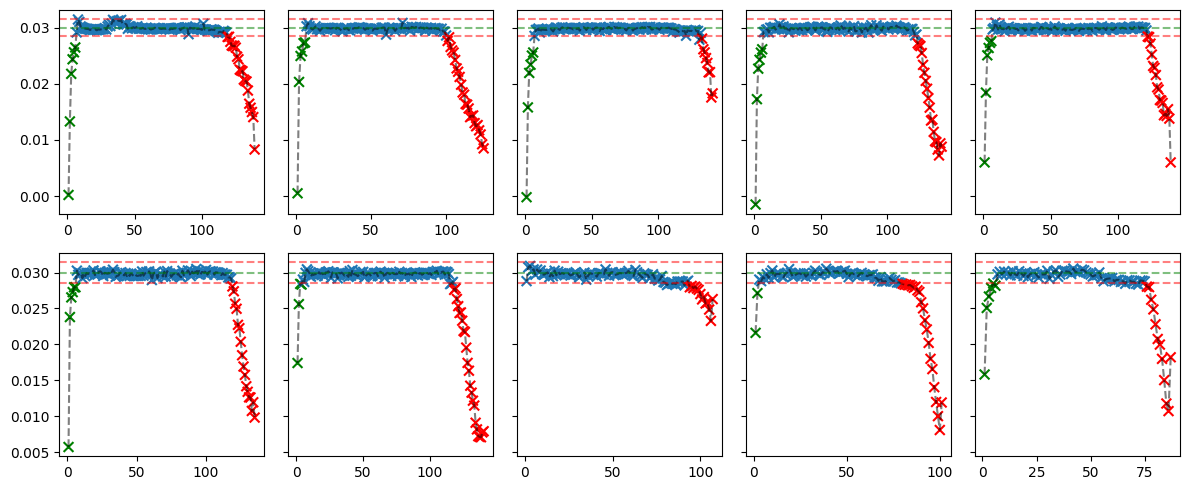

In [11]:
# scatter plot with color coding for classes

fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['g' if x == 0 else 'r' if x == 2 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## ML Data Setup

In [12]:
# Join all exp dataframes
main_df = pd.concat(dfs, ignore_index=True)
# Remove any rows with NaN values, mainly at the start of the experiment
main_df = main_df.dropna()
# Reset dataframe index
main_df = main_df.reset_index(drop=True)

# Remove unwanted feature columns from dataframe
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Mean radius',
                                'Radius diff',
                                'Avg probe',
                                'Probe diff',
                                # 'Freq 10 kHz',
                                # 'Probe cat',
                                ])
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1255 rows x 10 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Freq 350 kHz,Freq 900 kHz,Probe class
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432,-2.844005,-17.895705,0
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882,19.105036,-14.475323,0
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065,26.394282,-10.499393,0
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375,27.325377,-9.707462,0
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941,26.678019,-10.607793,0


In [13]:
# Split into input and target dataframes
input_df = main_df.iloc[:, :-1].copy()
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')

target_df = main_df.iloc[:, -1].copy()
target_df = keras.utils.to_categorical(target_df)
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')

Input df : 1255 rows x 9 cols
Target df : 1255 rows x 3 cols


In [14]:
target_df

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [15]:
# Show percentage of each class within dataframe
percent = np.sum(target_df, axis=0) / np.sum(target_df) * 100
print('Dataset Class Split:')
for i, p in enumerate(percent):
    print(f'Class {i}: {p:.2f}%')

Dataset Class Split:
Class 0: 3.82%
Class 1: 81.83%
Class 2: 14.34%


In [16]:
# Split data into training and testing sets, stratifiy keeps the class distribution the same in both sets
idx = np.arange(input_df.shape[0])
idx_train, idx_test = train_test_split(idx,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=target_df,
                                       )

print(f'Training set: {len(idx_train)} samples')
print(f'Testing set: {len(idx_test)} samples')

Training set: 878 samples
Testing set: 377 samples


In [17]:
# Scale input data based on solely the training set
scaler = MinMaxScaler()
scaler.fit(input_df.iloc[idx_train])
input_df = scaler.transform(input_df)

## Classification Model

### Setup

In [18]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape=(input_df.shape[1],)))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(target_df.shape[1], activation='softmax'))

In [19]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475 (5.76 KB)

 Trainable params: 1,475 (5.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the model
mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'f1_score'],
            )

### Training

In [21]:
history = mlp.fit(input_df[idx_train],
                  target_df[idx_train],
                  epochs=1000,
                  batch_size=32,
                  validation_data=(input_df[idx_test], target_df[idx_test]),
                  verbose=0,
                  callbacks=[TqdmCallback(verbose=0, tqdm_class=tqdm.tqdm),],
                  )

100%|██████████| 1000/1000 [01:47<00:00,  9.34epoch/s, accuracy=0.984, f1_score=tf.Tensor([0.9850746  0.99030465 0.94693875], shape=(3,), dtype=float32), loss=0.0431, val_accuracy=0.963, val_f1_score=tf.Tensor([0.8571428  0.97899836 0.89719623], shape=(3,), dtype=float32), val_loss=0.116]


Text(0, 0.5, 'Loss')

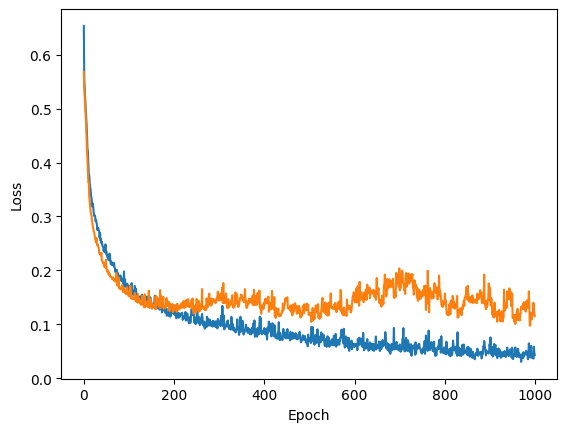

In [22]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

### Evaluation

In [23]:
sc = mlp.evaluate(input_df[idx_test], target_df[idx_test], batch_size=32, return_dict=True, verbose=0)
print('Test set evaluation:')
for key, val in sc.items():
    if key == 'loss':
        continue
    try:
        print(f'{key.capitalize()}: {val:.4f}')
    except TypeError:
        print(f'{key.capitalize()}: {val}')

Test set evaluation:
Accuracy: 0.9629
F1_score: [0.8571428  0.97899836 0.89719623]


### Thresholding

The MLP model returns the probability of that sample fitting into each class. 

Therefore to get a class prediction we choose the class with the highest probability.

In [24]:
y_pred = mlp.predict(input_df, verbose=0)

In [25]:
# Get the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

### Confusion matrix

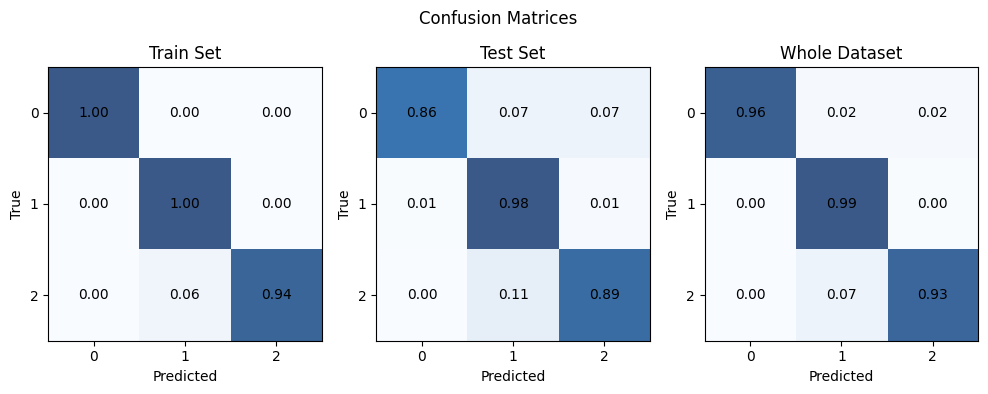

In [26]:
# confusion matrix of test train and whole dataset
cm_true = pd.Series(np.argmax(target_df, axis=1))
cm_pred = pd.Series(y_pred_class)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Confusion Matrices')

datasets = [idx_train, idx_test, np.arange(input_df.shape[0])]
for i, data in enumerate(datasets):
    cm = pd.crosstab(cm_true[data], cm_pred[data], rownames=['True'], colnames=['Predicted'])
    cm = cm.div(cm.sum(axis=1), axis='index')
    ax[i].imshow(cm, cmap='Blues', alpha=0.8)
    for ix in range(cm.shape[0]):
        for jx in range(cm.shape[1]):
            ax[i].text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.2f}', ha='center', va='center')
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_yticks(np.arange(cm.shape[0]))
    if i == 0:
        ax[i].set_title('Train Set')
    elif i == 1:
        ax[i].set_title('Test Set')
    else:
        ax[i].set_title('Whole Dataset')

    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')


### Classification Visualisation

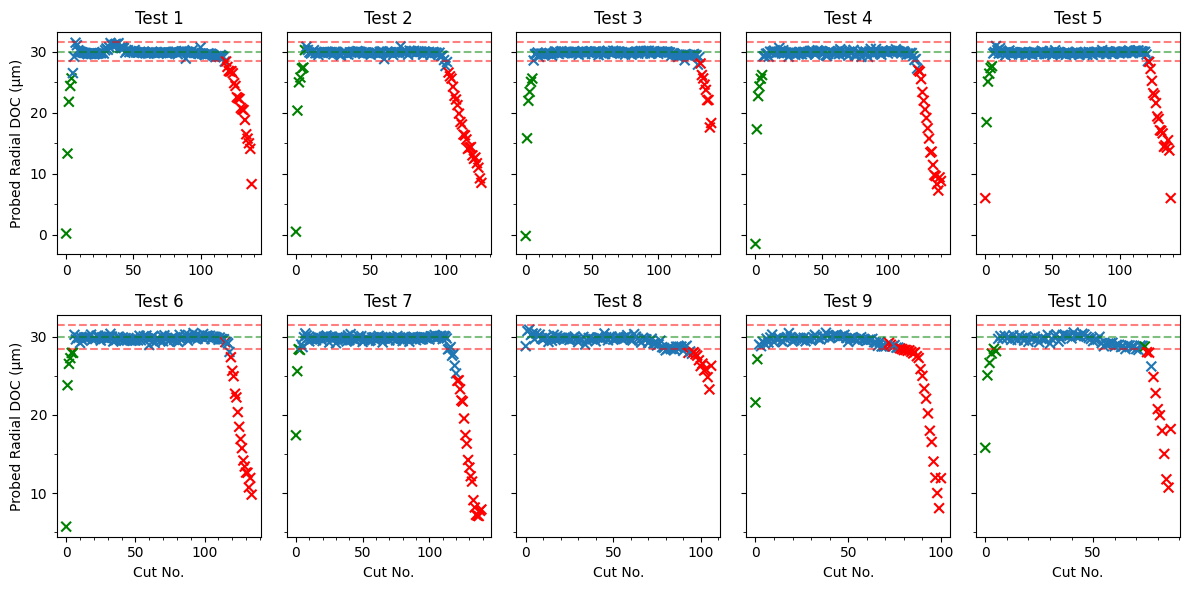

In [27]:
pred_df = pd.concat([df.copy().dropna() for df in dfs])
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = y_pred_class

x = pred_df.index
col = np.empty_like(x, dtype=object)
col.fill('C0')
col[pred_df['Probe pred'] == 0] = 'g'
col[pred_df['Probe pred'] == 2] = 'r'

fig, ax = plt.subplots(2, 5, figsize=(12, 6), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df.dropna()) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()

for i in range(len(ax)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].dropna().values))
    y = dfs[i].dropna()['Probe diff'].values * 1000
    ax[i].scatter(x=x, y=y, color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    # ax[i].set_ylim(-1, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 5:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()

# Binary classification (In Tol, Out Tol)

Only use two classes in or out of tolerance for probe doc.

Labelling Key:
- 0 : In tolerance
- 1 : Out of tolerance

## Data Preprocesssing & Labelling

In [28]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\tomje\AppData\Local\Temp\ipykernel_50836\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_50836\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


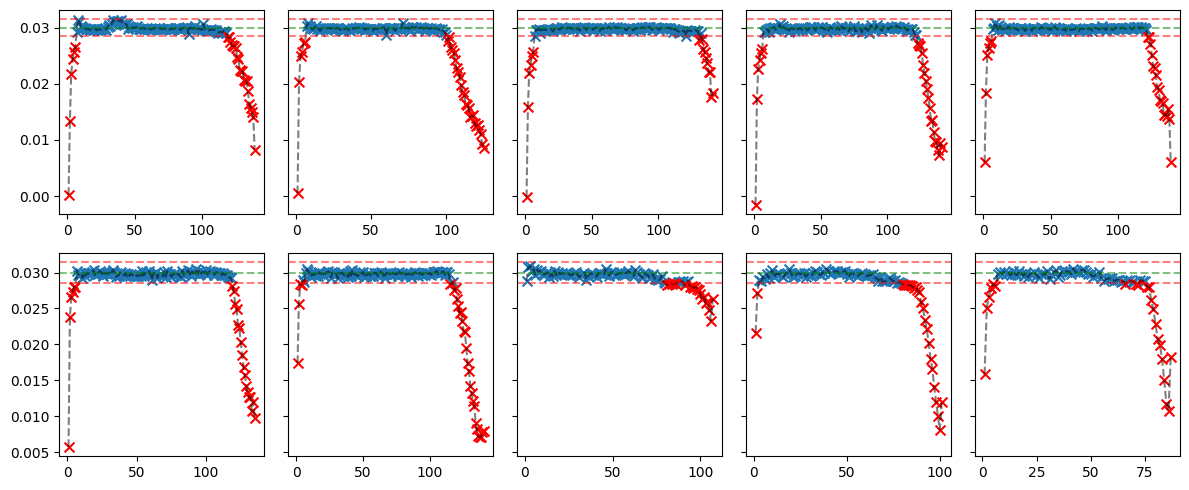

In [29]:
categories = []

fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()
for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)
    categories.append(tol_bool)

    in_tol = y.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)
fig.tight_layout()


In [30]:
# Multi-class classification
for df, cat in zip(dfs, categories):
    df['Probe class'] = cat 

c:\Users\tomje\.conda\envs\tf\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


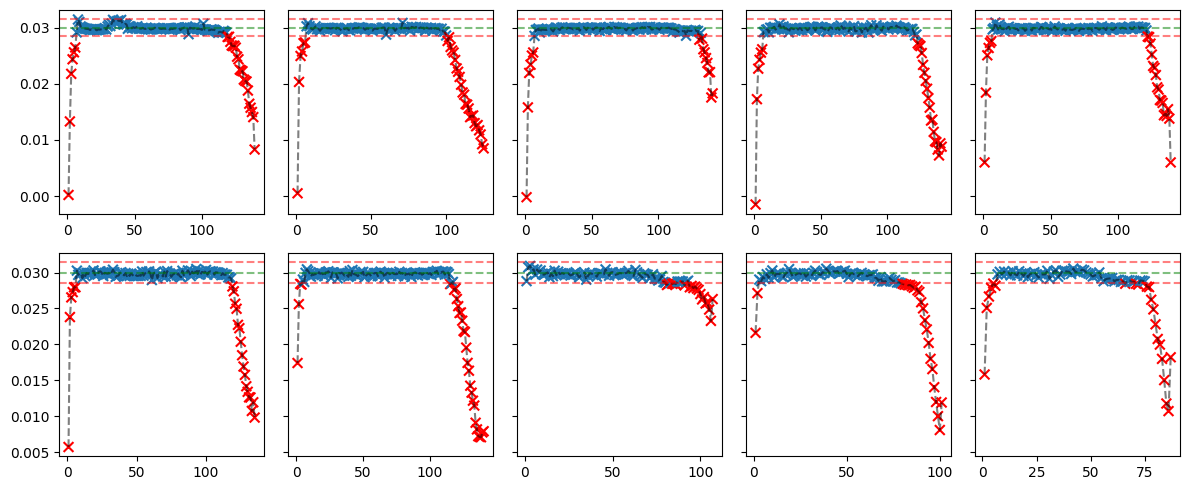

In [31]:
# scatter plot with color coding for classes

fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['g' if x == -1 else 'r' if x == 1 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## ML Data Setup

In [32]:
# Join all exp dataframes
main_df = pd.concat(dfs, ignore_index=True)
# Remove any rows with NaN values, mainly at the start of the experiment
main_df = main_df.dropna()
# Reset dataframe index
main_df = main_df.reset_index(drop=True)

# Remove unwanted feature columns from dataframe
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Mean radius',
                                'Radius diff',
                                'Avg probe',
                                'Probe diff',
                                # 'Freq 10 kHz',
                                # 'Probe cat',
                                ])
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1255 rows x 10 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Freq 350 kHz,Freq 900 kHz,Probe class
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432,-2.844005,-17.895705,True
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882,19.105036,-14.475323,True
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065,26.394282,-10.499393,True
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375,27.325377,-9.707462,True
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941,26.678019,-10.607793,True


In [33]:
# Split into input and target dataframes
input_df = main_df.iloc[:, :-1].copy()
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')

target_df = main_df.iloc[:, -1].copy()
target_df = keras.utils.to_categorical(target_df)
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')

Input df : 1255 rows x 9 cols
Target df : 1255 rows x 2 cols


In [34]:
target_df

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [35]:
# Show percentage of each class within dataframe
percent = np.sum(target_df, axis=0) / np.sum(target_df) * 100
print('Dataset Class Split:')
for i, p in enumerate(percent):
    print(f'Class {i}: {p:.2f}%')

Dataset Class Split:
Class 0: 80.96%
Class 1: 19.04%


In [36]:
# Split data into training and testing sets, stratifiy keeps the class distribution the same in both sets
idx = np.arange(input_df.shape[0])
idx_train, idx_test = train_test_split(idx,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=target_df,
                                       )

print(f'Training set: {len(idx_train)} samples')
print(f'Testing set: {len(idx_test)} samples')

Training set: 878 samples
Testing set: 377 samples


In [37]:
# Scale input data based on solely the training set
scaler = MinMaxScaler()
scaler.fit(input_df.iloc[idx_train])
input_df = scaler.transform(input_df)

In [38]:
from sklearn.decomposition import PCA
pca_input = input_df.copy()
pca_input = PCA(n_components=5).fit_transform(pca_input)

In [39]:
pca_input.shape

(1255, 5)

## Classification Model

### Setup

In [40]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape=(input_df.shape[1],)))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(target_df.shape[1], activation='softmax'))

In [41]:
mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442 (5.63 KB)

 Trainable params: 1,442 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Compile the model
mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'f1_score'],
            )

### Training

In [43]:
history = mlp.fit(input_df[idx_train],
                  target_df[idx_train],
                  epochs=1000,
                  batch_size=32,
                  validation_data=(input_df[idx_test], target_df[idx_test]),
                  verbose=0,
                  callbacks=[TqdmCallback(verbose=0, tqdm_class=tqdm.tqdm),],
                  )

100%|██████████| 1000/1000 [01:45<00:00,  9.45epoch/s, accuracy=0.972, f1_score=tf.Tensor([0.98250514 0.9235473 ], shape=(2,), dtype=float32), loss=0.087, val_accuracy=0.96, val_f1_score=tf.Tensor([0.97545004 0.8951049 ], shape=(2,), dtype=float32), val_loss=0.19]  


Text(0, 0.5, 'Loss')

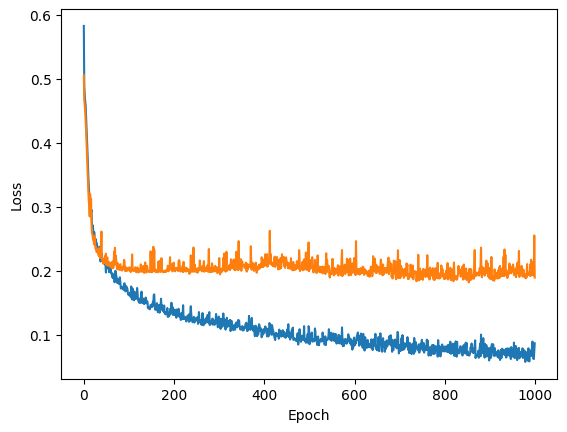

In [44]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

### Evaluation

In [45]:
sc = mlp.evaluate(input_df[idx_test], target_df[idx_test], batch_size=32, return_dict=True, verbose=0)
print('Test set evaluation:')
for key, val in sc.items():
    if key == 'loss':
        continue
    try:
        print(f'{key.capitalize()}: {val:.4f}')
    except TypeError:
        print(f'{key.capitalize()}: {val}')

Test set evaluation:
Accuracy: 0.9602
F1_score: [0.97545004 0.8951049 ]


### Thresholding

The MLP model returns the probability of that sample fitting into each class. 

Therefore to get a class prediction could choose the class with the highest probability, or set a threshold to determine the class.

In [46]:
y_pred = mlp.predict(input_df, verbose=0)

In [47]:
# Get the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

In [48]:
# Threshold based class prediction
threshold = 0.5
y_pred_class = y_pred[:, 1] > threshold

### Confusion matrix

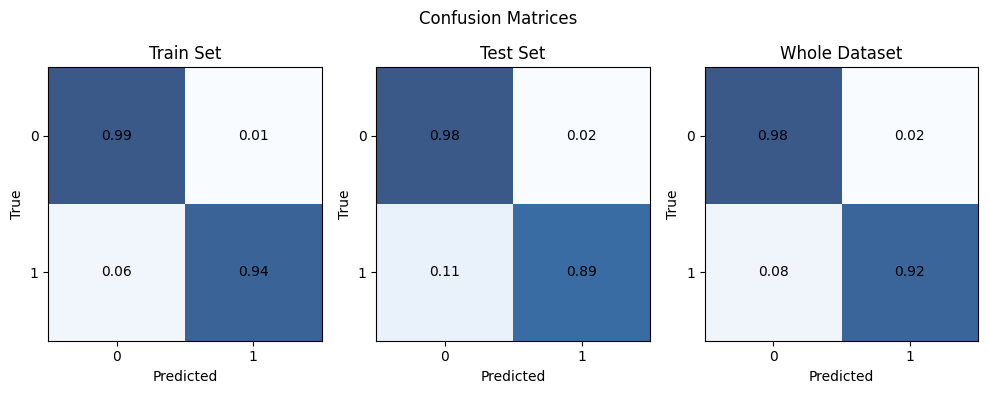

In [49]:
# confusion matrix of test train and whole dataset
cm_true = pd.Series(np.argmax(target_df, axis=1))
cm_pred = pd.Series(y_pred_class)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Confusion Matrices')

datasets = [idx_train, idx_test, np.arange(input_df.shape[0])]
for i, data in enumerate(datasets):
    cm = pd.crosstab(cm_true[data], cm_pred[data], rownames=['True'], colnames=['Predicted'])
    cm = cm.div(cm.sum(axis=1), axis='index')
    ax[i].imshow(cm, cmap='Blues', alpha=0.8)
    for ix in range(cm.shape[0]):
        for jx in range(cm.shape[1]):
            ax[i].text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.2f}', ha='center', va='center')
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_yticks(np.arange(cm.shape[0]))
    if i == 0:
        ax[i].set_title('Train Set')
    elif i == 1:
        ax[i].set_title('Test Set')
    else:
        ax[i].set_title('Whole Dataset')

    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')


### Classification Visualisation

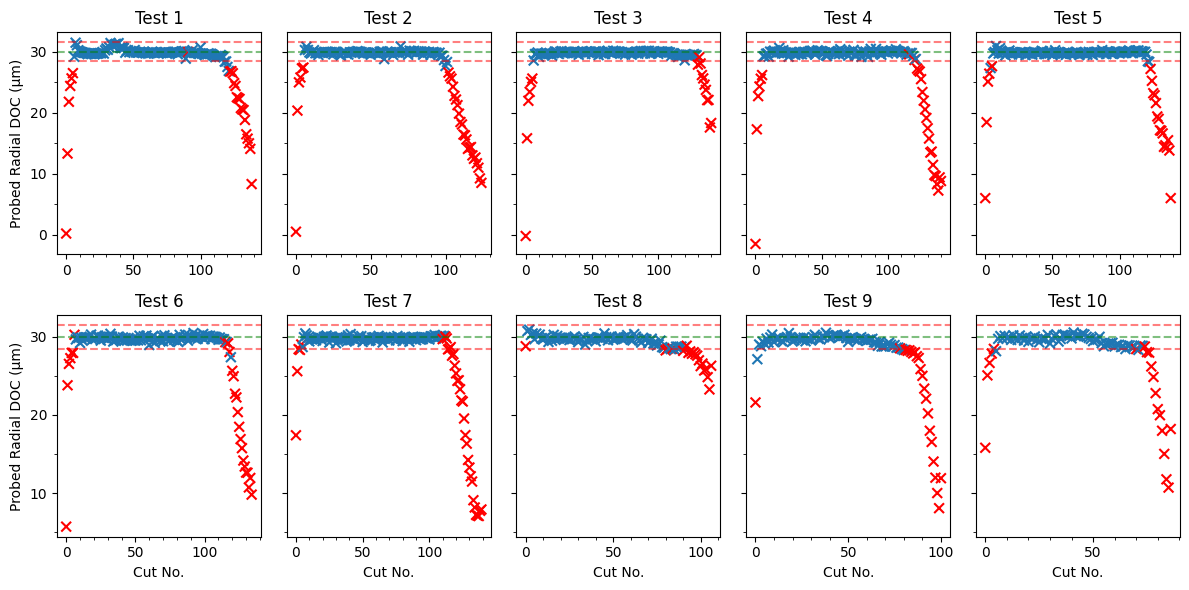

In [50]:
pred_df = pd.concat([df.copy().dropna() for df in dfs])
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = y_pred_class

x = pred_df.index
col = np.empty_like(x, dtype=object)
col.fill('C0')
col[pred_df['Probe pred'] == 1] = 'r'

fig, ax = plt.subplots(2, 5, figsize=(12, 6), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df.dropna()) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()

for i in range(len(ax)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].dropna().values))
    y = dfs[i].dropna()['Probe diff'].values * 1000
    ax[i].scatter(x=x, y=y, color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    # ax[i].set_ylim(-1, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 5:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()

# Binary classification without wear in data (Steady State, Wear Out)

Wear out is more important to detect than wear in. Therefore, how would classifcation change if we solely focused on wear out data?

Therefore only two classes are used in this case.

Labelling Key:
- 0: Stage 2 (Steady state)
- 1 : Stage 3 (Wear out)

## Data Preprocesssing & Labelling

In [7]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\c1717070\AppData\Local\Temp\ipykernel_9996\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\c1717070\AppData\Local\Temp\ipykernel_9996\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


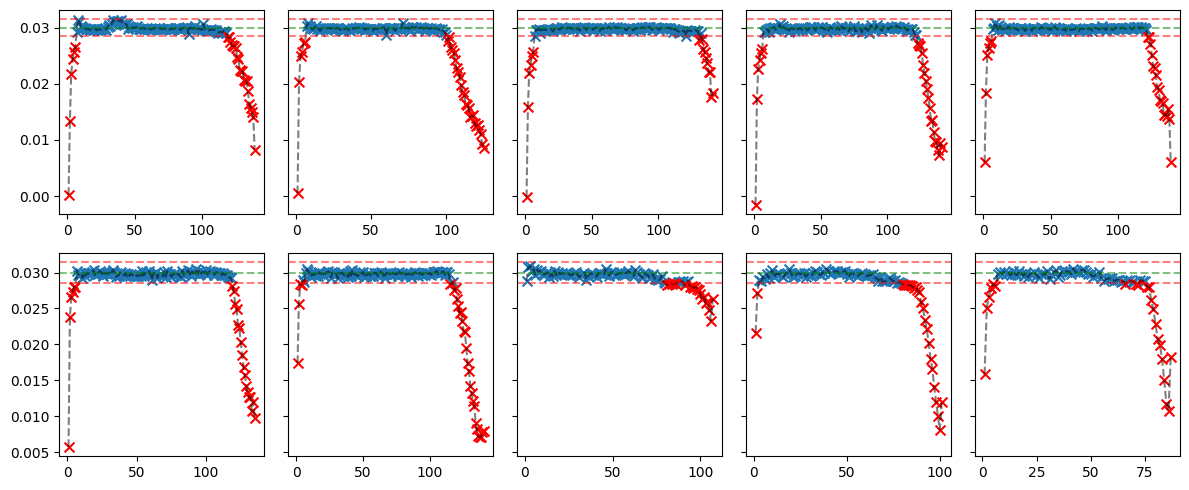

In [8]:
crossings = []

fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()
for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)

    in_tol = y.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)

    crossing = []
    for ix in x[tol_bool]:
        # if ix == 0:
        #     continue
        # if ix == len(x) - 1:
        #     continue
        if ix - 1 not in x[tol_bool]:
            crossing.append(ix)
        elif ix + 1 not in x[tol_bool]:
            crossing.append(ix)

    # if len(crossing) != 2:
    #     ix = np.argmax(np.diff(crossing))
    #     crossing = crossing[ix:ix+2]
    crossing = [crossing[1], crossing[-2]]
    crossings.append(crossing)

fig.tight_layout()


In [9]:
# test 8 has no wear in stage
crossings[7][0] = 0
crossings

[[6, 119],
 [6, 101],
 [6, 133],
 [6, 123],
 [6, 122],
 [6, 119],
 [4, 118],
 [0, 94],
 [2, 80],
 [6, 76]]

In [10]:
# Multi-class classification
categories = []
for df, cr in zip(dfs, crossings):
    categories.append(np.zeros(len(df), dtype=int))
    categories[-1][:cr[0] + 1] = -1
    categories[-1][cr[1]:] = 1
    df['Probe class'] = categories[-1]

In [11]:
# Remove all data with category of -1 
for df, cat in zip(dfs, categories):
    df['Probe class'] = cat
    df.drop(df[df['Probe class'] == -1].index, inplace=True)

c:\Users\c1717070\AppData\Local\miniconda3\envs\tf\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


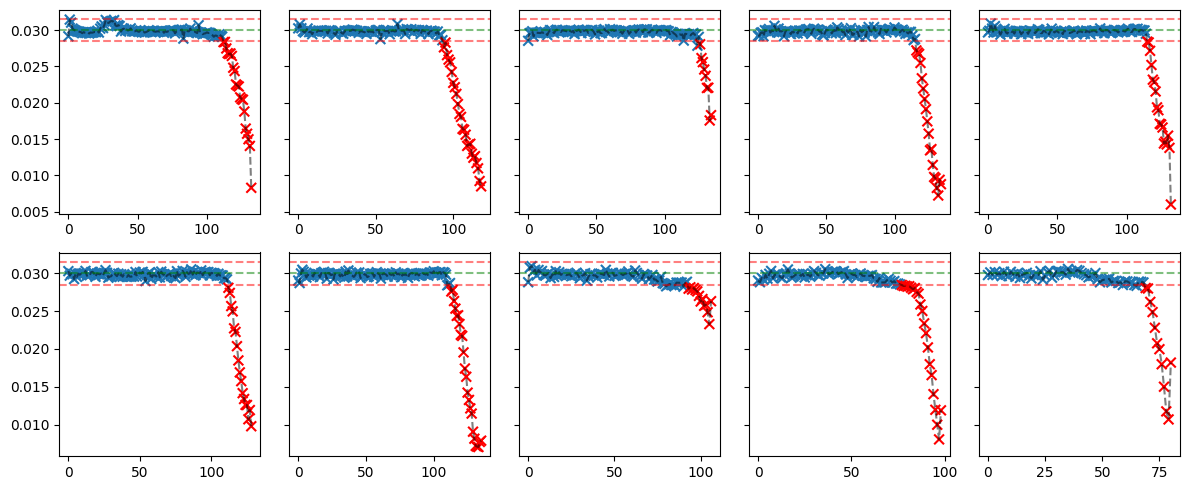

In [12]:
# scatter plot with color coding for classes
fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['C0' if x == -1 else 'r' if x == 1 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## ML Data Setup

In [13]:
# Join all exp dataframes
main_df = pd.concat(dfs, ignore_index=True)
# Remove any rows with NaN values, mainly at the start of the experiment
main_df = main_df.dropna()
# Reset dataframe index
main_df = main_df.reset_index(drop=True)

# Remove unwanted feature columns from dataframe
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Mean radius',
                                'Radius diff',
                                'Avg probe',
                                'Probe diff',
                                # 'Freq 10 kHz',
                                # 'Probe cat',
                                ])
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1207 rows x 10 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Freq 350 kHz,Freq 900 kHz,Probe class
0,1.018375,5.347006,11.570679,-0.088832,34.427976,66.918001,48.981869,26.650652,-10.713671,0
1,1.009624,5.263375,8.932589,-0.076673,34.011602,67.002293,49.102665,26.525174,-10.916002,0
2,1.020696,5.053545,8.965567,-0.080030,34.109063,67.436460,49.450305,26.476995,-10.993286,0
3,1.044284,5.061466,9.420055,-0.091577,34.196497,67.539986,49.570803,26.377297,-11.133766,0
4,1.045896,4.991534,10.239016,-0.086686,34.402094,67.449424,49.715149,26.336164,-11.347432,0


In [14]:
# Split into input and target dataframes
input_df = main_df.iloc[:, :-1].copy()
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')

target_df = main_df.iloc[:, -1].copy()
target_df = keras.utils.to_categorical(target_df)
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')

Input df : 1207 rows x 9 cols
Target df : 1207 rows x 2 cols


In [15]:
target_df

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [16]:
# Show percentage of each class within dataframe
percent = np.sum(target_df, axis=0) / np.sum(target_df) * 100
print('Dataset Class Split:')
for i, p in enumerate(percent):
    print(f'Class {i}: {p:.2f}%')

Dataset Class Split:
Class 0: 85.09%
Class 1: 14.91%


In [17]:
# Split data into training and testing sets, stratifiy keeps the class distribution the same in both sets
idx = np.arange(input_df.shape[0])
idx_train, idx_test = train_test_split(idx,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=target_df,
                                       )

print(f'Training set: {len(idx_train)} samples')
print(f'Testing set: {len(idx_test)} samples')

Training set: 844 samples
Testing set: 363 samples


In [18]:
# Scale input data based on solely the training set
scaler = MinMaxScaler()
scaler.fit(input_df.iloc[idx_train])
input_df = scaler.transform(input_df)

## Classification Model

### Setup

In [19]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape=(input_df.shape[1],)))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(target_df.shape[1], activation='softmax'))

In [20]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442 (5.63 KB)

 Trainable params: 1,442 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile the model
mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'f1_score'],
            )

### Training

In [22]:
history = mlp.fit(input_df[idx_train],
                  target_df[idx_train],
                  epochs=1000,
                  batch_size=32,
                  validation_data=(input_df[idx_test], target_df[idx_test]),
                  verbose=0,
                  callbacks=[TqdmCallback(verbose=0, tqdm_class=tqdm.tqdm),],
                  )

100%|██████████| 1000/1000 [01:24<00:00, 11.88epoch/s, accuracy=0.991, f1_score=tf.Tensor([0.99442893 0.9682539 ], shape=(2,), dtype=float32), loss=0.0219, val_accuracy=0.981, val_f1_score=tf.Tensor([0.98858076 0.938053  ], shape=(2,), dtype=float32), val_loss=0.0555]


Text(0, 0.5, 'Loss')

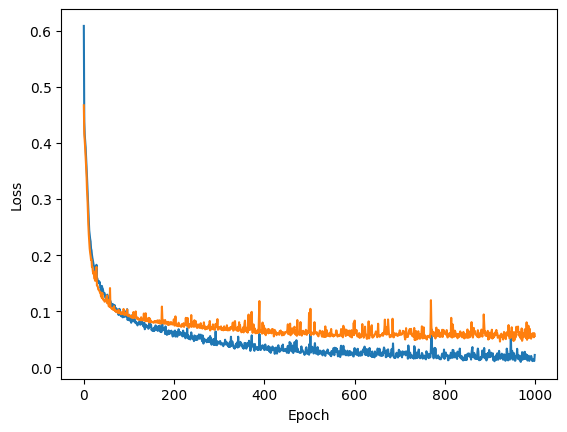

In [23]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

### Evaluation

In [24]:
sc = mlp.evaluate(input_df[idx_test], target_df[idx_test], batch_size=32, return_dict=True, verbose=0)
print('Test set evaluation:')
for key, val in sc.items():
    if key == 'loss':
        continue
    try:
        print(f'{key.capitalize()}: {val:.4f}')
    except TypeError:
        print(f'{key.capitalize()}: {val}')

Test set evaluation:
Accuracy: 0.9807
F1_score: [0.98858076 0.938053  ]


### Thresholding

The MLP model returns the probability of that sample fitting into each class. 

Therefore to get a class prediction we choose the class with the highest probability.

In [25]:
y_pred = mlp.predict(input_df, verbose=0)

In [26]:
# Get the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

In [27]:
# Threshold based class prediction
threshold = 0.2
y_pred_class = y_pred[:, 1] > threshold

### Confusion matrix

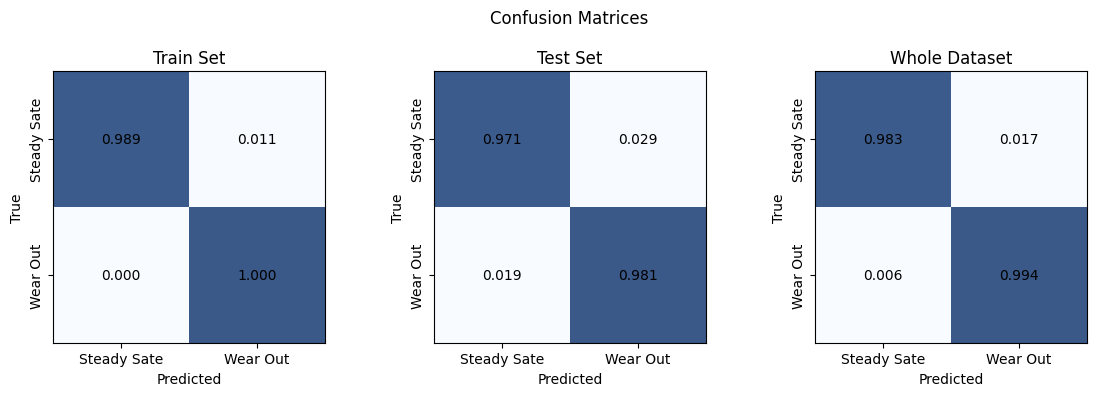

In [34]:
# confusion matrix of test train and whole dataset
cm_true = pd.Series(np.argmax(target_df, axis=1))
cm_pred = pd.Series(y_pred_class)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Confusion Matrices')

datasets = [idx_train, idx_test, np.arange(input_df.shape[0])]
for i, data in enumerate(datasets):
    cm = pd.crosstab(cm_true[data], cm_pred[data], rownames=['True'], colnames=['Predicted'])
    cm = cm.div(cm.sum(axis=1), axis='index')
    ax[i].imshow(cm, cmap='Blues', alpha=0.8)
    for ix in range(cm.shape[0]):
        for jx in range(cm.shape[1]):
            ax[i].text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.3f}', ha='center', va='center')
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_xticklabels(['Steady Sate', 'Wear Out'])
    ax[i].set_yticks(np.arange(cm.shape[0]))
    ax[i].set_yticklabels(['Steady Sate', 'Wear Out'], rotation=90, va='center')
    if i == 0:
        ax[i].set_title('Train Set')
    elif i == 1:
        ax[i].set_title('Test Set')
    else:
        ax[i].set_title('Whole Dataset')

    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')

    fig.tight_layout()


### Classification Visualisation

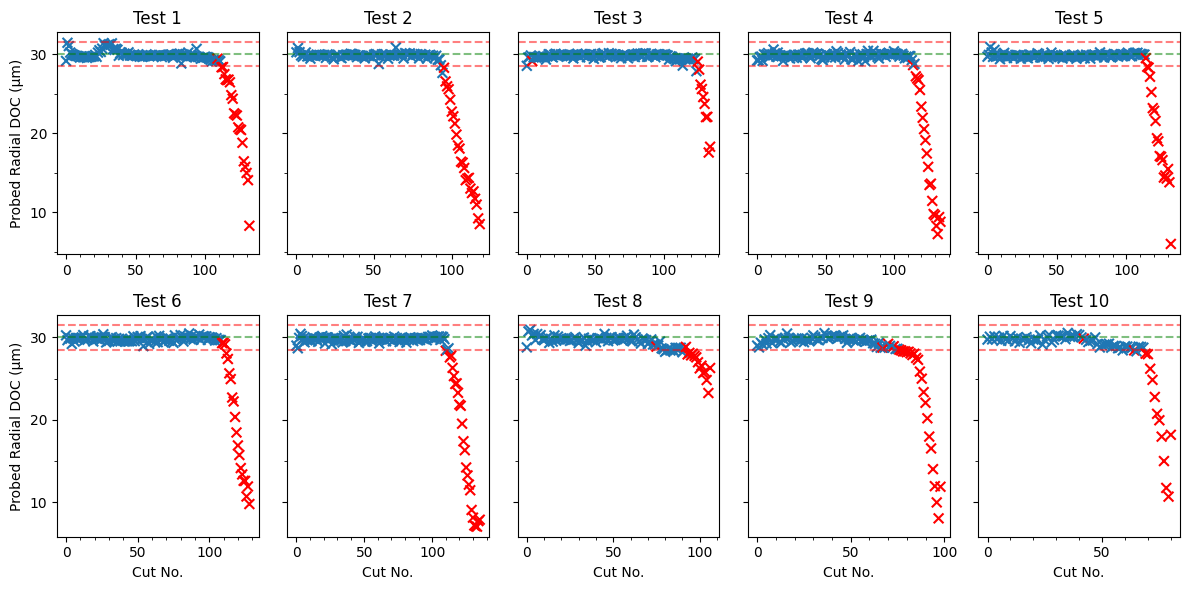

In [29]:
pred_df = pd.concat([df.copy().dropna() for df in dfs])
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = y_pred_class

x = pred_df.index
col = np.empty_like(x, dtype=object)
col.fill('C0')
col[pred_df['Probe pred'] == 1] = 'r'

fig, ax = plt.subplots(2, 5, figsize=(12, 6), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df.dropna()) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()

for i in range(len(ax)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].dropna().values))
    y = dfs[i].dropna()['Probe diff'].values * 1000
    ax[i].scatter(x=x, y=y, color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    # ax[i].set_ylim(-1, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 5:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()

[0, 133, 252, 387, 522, 655, 784, 920, 1027, 1126, 1207]


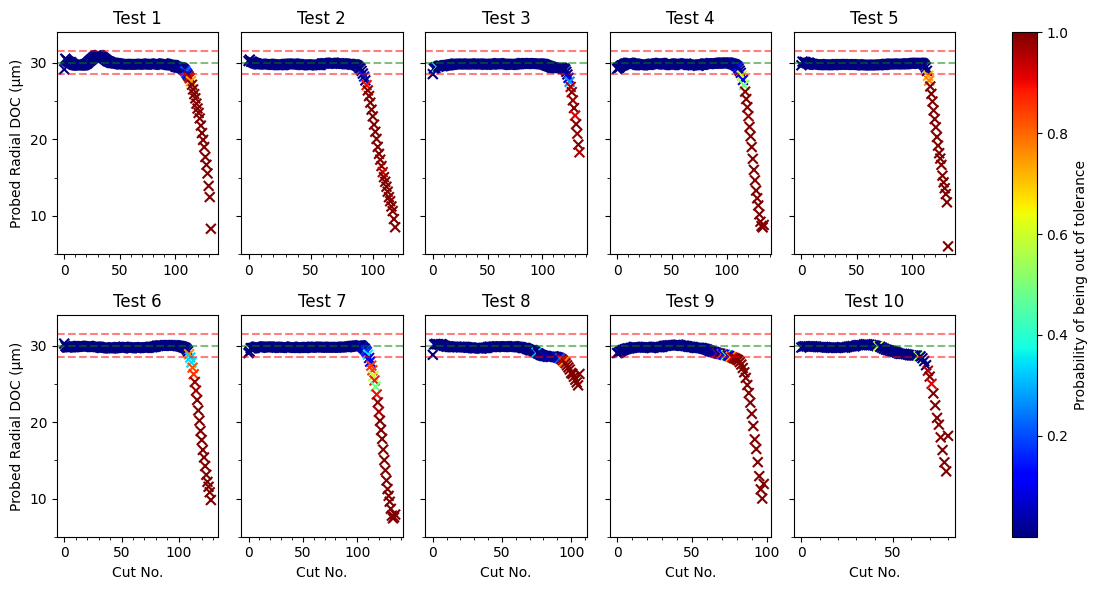

In [30]:
# plot scatter plot with color indicating the probability of being in tolerance
prob_class1 = y_pred[:, 1]
pred_df = pd.concat(dfs.copy())
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = prob_class1

x = pred_df.index
col = prob_class1

fig, ax = plt.subplots(2, 5, figsize=(12, 6), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()
print(dfLen)

for i in range(len(ax)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].values))
    y = dfs[i]['Probe diff'].values * 1000
    y = _smooth(y, 11)
    sc = ax[i].scatter(x=x, y=y, c=col[dfLen[i]:dfLen[i+1]], marker='x', s=50, cmap='jet')
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].set_ylim(5, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 5:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()
fig.colorbar(sc, ax=ax, label='Probability of being out of tolerance')